In [1]:
%matplotlib inline
import numpy as np
from redrock.external import boss
from redrock.dataobj import MultiprocessingSharedSpectrum
from redrock import zfind
from redrock.io import read_templates


Read the data: fibers 42, 278, 314, 413 and 872 of spPlate-3678-55208.fits.
* If fiberid is not specified, all fibers from the plate are read.
* If use_frames is True, the individual exposures will be discovered from the spPlate header. The corresponding spCFrame files should be in the same directory as the spPlate file.
* BEWARE: The targets list might not have the same order as the input fiberid

**NOTE**: BOSS/eBOSS is publicly accessible and can be downloaded
from https://data.sdss.org/sas/dr14/eboss/spectro/redux/

They are also available at NERSC: /project/projectdirs/cosmo/data/sdss/dr14/eboss/spectro/redux/

In [2]:
spplate="data/spPlate-3678-55208.fits"
targets,meta = boss.read_spectra(spplate, spectrum_class=MultiprocessingSharedSpectrum,\
                                 use_frames=False, fiberid=[42,278,314,413,872])

DEBUG: read data/spPlate-3678-55208.fits 


# Doing the redshifts scans

Define the templates and to the redshift scans over those templates.

This might take a few minutes, please be patient! Your computer is working hard.

In [3]:
templates = read_templates()
zscan,zfit = zfind(targets,templates)

INFO: using multiprocessing with 2 cores
DEBUG: PID 6181 GALAXY zscan in 19.2 seconds
DEBUG: PID 6181 GALAXY fitz in 2.7 seconds
DEBUG: PID 6181 QSO zscan in 6.1 seconds
DEBUG: PID 6181 QSO fitz in 1.7 seconds
DEBUG: PID 6181 STAR:A zscan in 1.9 seconds
DEBUG: PID 6181 STAR:A fitz in 1.6 seconds
DEBUG: PID 6181 STAR:B zscan in 2.0 seconds
DEBUG: PID 6181 STAR:B fitz in 1.5 seconds
DEBUG: PID 6181 STAR:F zscan in 1.8 seconds
DEBUG: PID 6181 STAR:F fitz in 1.7 seconds
DEBUG: PID 6181 STAR:G zscan in 2.2 seconds
DEBUG: PID 6181 STAR:G fitz in 1.4 seconds
DEBUG: PID 6181 STAR:K zscan in 1.8 seconds
DEBUG: PID 6181 STAR:K fitz in 1.5 seconds
DEBUG: PID 6181 STAR:M zscan in 1.7 seconds
DEBUG: PID 6181 STAR:M fitz in 1.4 seconds


# Exploring the output

The zscan dictionary contains the all the redshift scan information for each target and each template.

For example, here's a plot of the $\chi^2$ vs $z$ for the first target.


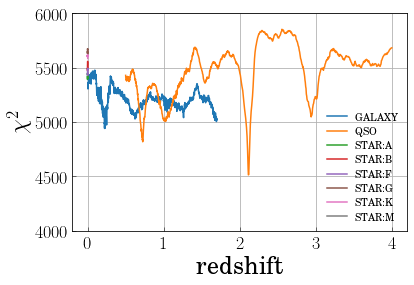

In [5]:
targetid = targets[0].id
for template in templates:
    plot(zscan[targetid][template.fulltype]['redshifts'],\
         zscan[targetid][template.fulltype]['zchi2'],label=template.fulltype)

legend(loc=0,frameon=False)
ylim(4000,6000)
grid()
xlabel("redshift",fontsize=24)
ylabel("$\chi^2$",fontsize=24)

Excellent! We find that the best fit is corresponds to a QSO template at redshift around 2.1. 

Let's confirm that by looking at the zfit table:

In [6]:
print "Redrock thinks {} is a {} at redsfhit {}".format(targets[0].id,zfit[0]['spectype'],zfit[0]['z'])

Redrock thinks 3678552080872 is a QSO at redsfhit 2.1138782461


Let's now make a plot of the spectrum and its best fit. The best fit is obtained by evaluating the best fit template (in this case a QSO) at the best fit redsfhit. First, we need to find which template in the list corresponds to a QSO (yes, this is a bit contrived)

In [10]:
for i,t in enumerate(templates):
    print i,t.fulltype

0 GALAXY
1 QSO
2 STAR:A
3 STAR:B
4 STAR:F
5 STAR:G
6 STAR:K
7 STAR:M


We now evaluate the template number 'QSO' at the best fit redshift:

In [11]:
tid = targets[0].id
## several minima are stored in the zfit table
minumum_number = 0

## select the target id and minumum number
w = (zfit[:]['targetid']==tid) & (zfit[:]['znum']==minumum_number)

## now get the coefficients
coeff = zfit[w]['coeff'].reshape(-1)
zbest = zfit[w]['z'][0]

## compute the best fit:
fit = templates[1].eval(coeff[:4],targets[0].spectra[0].wave,zbest)

## remultiply by (1+z)
fit *= (1+zbest)

(-1, 6)

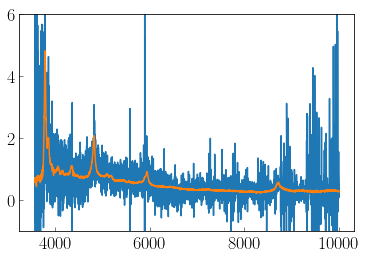

In [13]:
wave=targets[0].spectra[0].wave
flux = targets[0].spectra[0].flux
plot(wave,flux)
plot(wave,fit)
ylim(-1,6)

Let's add a bit of rebinning to smooth out the noise:

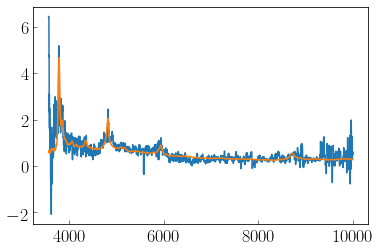

In [14]:
i = np.arange(len(fit),dtype=float)
A = i - i[:,None]
rebin = 5
w = abs(A)<rebin
A[w]=1.
A[~w]=0
A /= A.sum(axis=1).reshape(-1,1)
plot(wave,A.dot(flux))
plot(wave,A.dot(fit))